$x \in \mathbb{R}^d, y \in \mathbb{R}, k < d$, 
$$ y_i = \omega^Tx_i + \epsilon_i $$
$$\omega_j = \begin{cases} j/k, & \mbox{if j } \in \mbox{{1, . . . , k}} \\
0, & \mbox{otherwise}
\end{cases}$$
where  $\epsilon_i ~= N(0,\sigma^2)$

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=8,5
import matplotlib.pyplot as plt

In [2]:
# Generating synthetic dataset
np.random.seed(20)
n=500
d=1000
k=100

betaTrue = np.zeros(d+1)
for i in range(1,k+1):
    betaTrue[i] = i/k

C:\Users\cheol\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'beta(ground truth)')

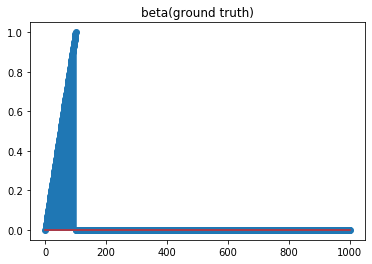

In [3]:
plt.stem(betaTrue)
plt.title('beta(ground truth)')

In [4]:
X = np.random.randn(n,d)
X = np.insert(X,0,1,axis = 1)
y = X @ betaTrue + np.random.randn(n)
y = y.reshape(-1,1)

In [5]:
def soft_threshold(rho,lamda):
    if rho < - lamda:
        return (rho + lamda)
    elif rho >  lamda:
        return (rho - lamda)
    else: 
        return 0
    
def coordinate_descent_lasso(theta,X,y,lamda = .01, num_iters=100, intercept = False):
    '''The intercept parameter allows to specify whether or not we regularize theta_0'''

    m,n = X.shape
    X = X / (np.linalg.norm(X,axis = 0)) #normalizing X 
    
    #Looping until max number of iterations
    for i in range(num_iters): 
        
        #Looping through each coordinate
        for j in range(n):
            
            #Vectorized implementation
            X_j = X[:,j].reshape(-1,1)
            y_pred = X @ theta
            rho = X_j.T @ (y - y_pred  + theta[j]*X_j)
        
            #Checking intercept parameter
            if intercept == True:  
                if j == 0: 
                    theta[j] =  rho 
                else:
                    theta[j] =  soft_threshold(rho, lamda)  

            if intercept == False:
                theta[j] =  soft_threshold(rho, lamda)   
            
    return theta.flatten()

In [62]:
# Initialize variables
mi,ni = X.shape
initial_theta = np.ones((ni,1))
theta_list = list()
lamda = np.logspace(0,4,100)/100 #Range of lambda values

In [63]:
for i in lamda:
    theta = coordinate_descent_lasso(initial_theta,X,y,lamda = i, num_iters=100)
    theta_list.append(theta)

In [64]:
#Stack into numpy array
theta_lasso = np.stack(theta_list).T

In [65]:
#Plot results
ni,_ = theta_lasso.shape
plt.figure(figsize = (12,8))

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

(0.00630957344480193, 158.48931924611142, -6.7795328847997, 25.033794583098466)

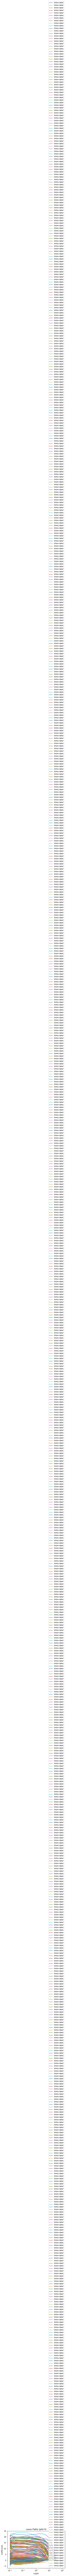

In [150]:
#From the plot, we can find lamda_max 
for i in range(ni):
    plt.plot(lamda, theta_lasso[i], label='Inline label')
plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths (plot 0)')
plt.legend(loc='lower right')
plt.axis('tight')

In [149]:
# Count non-zero variable from the theta_list for plot 1
def countNonzero(array):
    ct = 0
    for i in array:
        if i !=0:
            ct += 1
    return ct

# Count incorrect non-zero variable for plot 2
def incorrectNonzero(array):
    ct = 0
    for i in array[101:]:
        if i !=0:
            ct += 1
    return ct

# Count correct non-zero variable for plot 2
def correctNonzero(array):
    ct = 0
    for i in array[1:100]:
        if i !=0:
            ct += 1
    return ct

In [78]:
theta_count = list()
for i in theta_list:
    count = countNonzero(i)
    theta_count.append(count)

(0.00630957344480193, 158.48931924611142, -42.45, 891.45)

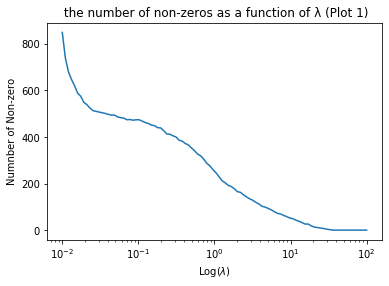

In [90]:
plt.figure()
plt.plot(lamda, theta_count)
plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Numnber of Non-zero')
plt.title(' the number of non-zeros as a function of λ (Plot 1)')
plt.axis('tight')

In [146]:
def calc_FDR(theta_list):
    fdr = list()
    for i in theta_list:
        count = countNonzero(i)
        if count == 0:
            count += 1
        incorrect_nonZero = incorrectNonzero(i)
        fdr.append(incorrect_nonZero/count)
    return fdr

In [142]:
def calc_TPR(theta_list):
    tpr = list()
    for i in theta_list:
        correct_nonZero = correctNonzero(i)
        tpr.append(correct_nonZero/100)
    return tpr

(-0.044169611307420496, 0.9275618374558303, -0.049, 1.029)

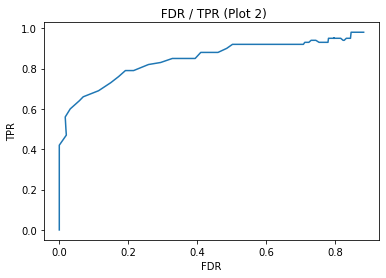

In [148]:
plt.figure()
plt.plot(calc_FDR(theta_list), calc_TPR(theta_list))
plt.xlabel('FDR')
plt.ylabel('TPR')
plt.title(' FDR / TPR (Plot 2)')
plt.axis('tight')

## Comment
- We generated 100 non-zero features. From the plot 0, we can find that $\lambda_(max) \approx 4.23$. 
- Plot 1 shows that number of non-zeros as a changing of lambda variable. lambda variable is exponentially increasing as a decreasing lambda variable, so called bias-variance trade-off. Therefore, we need to optimize lambda for better generalization.
- We can optimize lambda from the plot 2. We should decide balanced point between the maximized TPR and the minimized FDR. TPR = 0.8 might be one of the best pair of TPR and FDR.